In [1]:
import pandas
import torch
import os

os.environ['TORCH'] = torch.__version__

In [2]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 94.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 44.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/nightly/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 66.5 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-hnml0khg
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-hnml0khg
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit aae8bd25021f2f09c8919e752dd361f6dd997cd9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.8.0-py3-none-any.w

In [3]:
import pandas as pd
import numpy as np
import gc
import torch
from collections import defaultdict
from torch_geometric.data import Data
from torch_geometric.nn import LGConv 
from torch import nn
from torch_geometric.transforms import ToSparseTensor


In [4]:
DATA_DIR = "/kaggle/input/yambda-50m-compressed/yambda"
TRAIN_PQ = f"{DATA_DIR}/flat/50m/multi_event_train.parquet"
VAL_PQ = f"{DATA_DIR}/flat/50m/multi_event_val.parquet"
TEST_PQ = f"{DATA_DIR}/flat/50m/multi_event_test.parquet"


In [5]:
use_columns = ["uid", "timestamp", "item_id", "played_ratio_pct", "event_type"]
train_df = pd.read_parquet(TRAIN_PQ, columns=use_columns)
val_df = pd.read_parquet(VAL_PQ, columns=use_columns)
test_df = pd.read_parquet(TEST_PQ, columns=use_columns)


In [6]:
train_df['event_type'].value_counts()

event_type
listen       46013810
like           872573
unlike         310240
dislike        106966
undislike       20929
Name: count, dtype: int64

In [7]:
PRETRAIN_BEHAVIOR = "listen"
LISTEN_MIN_PCT = 50

def behavior_view(df, behavior, listen_min_pct=50):
    x = df[df['event_type'] == behavior].copy()
    if behavior == "listen":
        x = x[x["played_ratio_pct"] >= listen_min_pct]
    return x[["uid", "item_id"]].dropna()

pre_train = behavior_view(train_df, PRETRAIN_BEHAVIOR, LISTEN_MIN_PCT)

In [8]:
all_u = pd.Index(pd.concat([train_df["uid"], val_df["uid"], test_df["uid"]], 
                  ignore_index=True).unique())
all_i = pd.Index(pd.concat([train_df["item_id"], val_df["item_id"], test_df["item_id"]], 
                  ignore_index=True).unique())

In [9]:
u2id = pd.Series(np.arange(all_u.size, dtype=np.int64),index=all_u)
i2id = pd.Series(np.arange(all_i.size, dtype=np.int64),index=all_i)

U = u2id.size
I = i2id.size

In [10]:
pre_u = u2id.loc[pre_train["uid"]].to_numpy()
pre_i = i2id.loc[pre_train["item_id"]].to_numpy()

In [11]:
src = np.concatenate([pre_u, pre_i + U])
dst = np.concatenate([pre_i + U, pre_u])

edge_index = torch.tensor([src, dst], dtype=torch.long)
num_nodes = U + I

data = Data(edge_index=edge_index, num_nodes=num_nodes)
data

/tmp/ipykernel_19/1984929820.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([src, dst], dtype=torch.long)


Data(edge_index=[2, 58270372], num_nodes=944019)

In [12]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64, n_layers=3):
        super().__init__()
        self.U = num_users
        self.I = num_items
        self.N = num_users + num_items
        self.user = nn.Embedding(num_users, emb_dim)
        self.item = nn.Embedding(num_items, emb_dim)

        nn.init.xavier_uniform_(self.user.weight)
        nn.init.xavier_uniform_(self.item.weight)

        self.layers = nn.ModuleList([LGConv() for _ in range(n_layers)])
        
    def forward(self, edge_index, n_id=None, edge_weight=None):
        full = torch.cat([self.user.weight, self.item.weight], dim=0)
        x = full if n_id is None else full[n_id]
        acc = x.clone()
        for conv in self.layers:
            x = conv(x, edge_index)           
            acc.add_(x)
        return acc / (len(self.layers) + 1)   


    def score_pairs(self, u_abs, i_rel, node_emb):
        return (node_emb[u_abs] * node_emb[i_rel + self.U]).sum(dim=-1)

In [13]:
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling


prop_edge_index = data.edge_index

label_edge_index = torch.stack([
    torch.from_numpy(pre_u),                 # users (0..U-1)
    torch.from_numpy(pre_i + U)              # items (U..U+I-1)
], dim=0)

train_loader = LinkNeighborLoader(
    Data(edge_index=prop_edge_index, num_nodes=U+I),
    num_neighbors=[15, 10, 5],
    edge_label_index=label_edge_index,              
    neg_sampling=NegativeSampling(mode="triplet", amount=1),
    batch_size=8192, shuffle=True, directed=True
)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightGCN(U, I, emb_dim=64, n_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=0.0)


In [15]:
for epoch in range(1):
    model.train(); losses = []
    for i, batch in enumerate(train_loader):
        batch = batch.to(device)
        emb = model(batch.edge_index, n_id=batch.n_id)    # local
        u, ip, ineg = batch.src_index, batch.dst_pos_index, batch.dst_neg_index
        s_pos = (emb[u] * emb[ip]).sum(dim=-1)
        s_neg = (emb[u] * emb[ineg]).sum(dim=-1)
        loss = -torch.log(torch.sigmoid(s_pos - s_neg) + 1e-12).mean()
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        losses.append(loss.item())
        if (i % 200 == 0):
            print(f"epoch: {epoch+1}; batch: {i}/{len(train_loader)}, bpr: {loss:.8f}")
    print(f"epoch: {epoch+1}; bpr: {np.mean(losses):.8f}")

epoch: 1; batch: 0/3557, bpr: 0.69309711
epoch: 1; batch: 200/3557, bpr: 0.13778505
epoch: 1; batch: 400/3557, bpr: 0.11240280
epoch: 1; batch: 600/3557, bpr: 0.09541878
epoch: 1; batch: 800/3557, bpr: 0.09361098
epoch: 1; batch: 1000/3557, bpr: 0.07685903
epoch: 1; batch: 1200/3557, bpr: 0.07570545
epoch: 1; batch: 1400/3557, bpr: 0.06670750
epoch: 1; batch: 1600/3557, bpr: 0.05628300
epoch: 1; batch: 1800/3557, bpr: 0.05298924
epoch: 1; batch: 2000/3557, bpr: 0.05276882
epoch: 1; batch: 2200/3557, bpr: 0.04984819
epoch: 1; batch: 2400/3557, bpr: 0.04175905
epoch: 1; batch: 2600/3557, bpr: 0.04551464
epoch: 1; batch: 2800/3557, bpr: 0.04236357
epoch: 1; batch: 3000/3557, bpr: 0.04386016
epoch: 1; batch: 3200/3557, bpr: 0.04018905
epoch: 1; batch: 3400/3557, bpr: 0.04228534
epoch: 1; bpr: 0.07805565


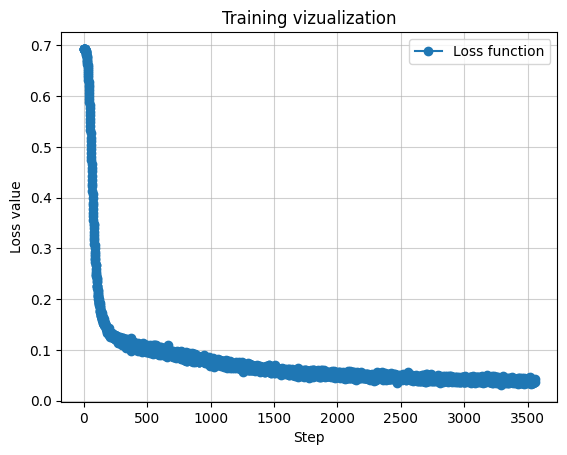

In [16]:
import matplotlib.pyplot as plt

plt.plot(losses, label="Loss function", marker='o')
plt.grid(True, alpha=0.6)
plt.xlabel("Step")
plt.ylabel("Loss value")
plt.title("Training vizualization")
plt.legend()
plt.savefig("training_viz")

In [17]:
data = ToSparseTensor()(data)     
adj_t = data.adj_t.to(device) 

In [18]:
import pyarrow as pa, pyarrow.parquet as pq 

model.eval()
with torch.no_grad():
    E = model(adj_t.to(device)).detach().cpu().numpy()

U_E = E[:U]
I_E = E[U:]

user_emb_df = pd.DataFrame(U_E)
user_emb_df.insert(0, "uid",  all_u.to_numpy())
item_emb_df = pd.DataFrame(I_E)
item_emb_df.insert(0, "item_id", all_i.to_numpy())

pq.write_table(pa.Table.from_pandas(user_emb_df), "lightgcn_user_emb.parquet")
pq.write_table(pa.Table.from_pandas(item_emb_df), 'lightgcn_item_emb.parquet')


/tmp/ipykernel_19/1937696263.py:15: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  pq.write_table(pa.Table.from_pandas(user_emb_df), "lightgcn_user_emb.parquet")
/tmp/ipykernel_19/1937696263.py:16: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  pq.write_table(pa.Table.from_pandas(item_emb_df), 'lightgcn_item_emb.parquet')


In [19]:
from torch_geometric.data import HeteroData
import torch

name_map = {"listen":"listens", "like":"likes", "unlike":"unlikes", "dislike":"dislikes", "undislike":"undislikes"}
behaviours = ["listens","likes","dislikes","unlikes","undislikes"]
bset = set(behaviours)

def df_to_edges(df, behaviour, listen_min_pct=50):
    df = df.copy()
    df = df[df["event_type"].map(name_map)==behaviour]
    if behaviour=="listens":
        df = df[df["played_ratio_pct"]>=listen_min_pct]
    if df.empty: 
        return None
    uu = torch.tensor(u2id.loc[df["uid"]].to_numpy(), dtype=torch.long)
    ii = torch.tensor(i2id.loc[df["item_id"]].to_numpy(), dtype=torch.long)
    return uu, ii

G_train = HeteroData()
G_train["user"].num_nodes = U
G_train["item"].num_nodes = I

for beh in behaviours:
    out = df_to_edges(train_df, beh, listen_min_pct=50)
    if out is None: 
        continue
    uu, ii = out
    G_train["user","%s"%beh,"item"].edge_index = torch.stack([uu, ii], dim=0)
    ru = ii
    rv = uu
    G_train["item","rev_%s"%beh,"user"].edge_index = torch.stack([ru, rv], dim=0)

print(G_train)


HeteroData(
  user={ num_nodes=10000 },
  item={ num_nodes=934019 },
  (user, listens, item)={ edge_index=[2, 29135186] },
  (item, rev_listens, user)={ edge_index=[2, 29135186] },
  (user, likes, item)={ edge_index=[2, 872573] },
  (item, rev_likes, user)={ edge_index=[2, 872573] },
  (user, dislikes, item)={ edge_index=[2, 106966] },
  (item, rev_dislikes, user)={ edge_index=[2, 106966] },
  (user, unlikes, item)={ edge_index=[2, 310240] },
  (item, rev_unlikes, user)={ edge_index=[2, 310240] },
  (user, undislikes, item)={ edge_index=[2, 20929] },
  (item, rev_undislikes, user)={ edge_index=[2, 20929] }
)


In [20]:
d = U_E.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G_train["user"].x = torch.tensor(U_E, dtype=torch.float32)
G_train["item"].x = torch.tensor(I_E, dtype=torch.float32)
G_train = G_train.to(device)


In [21]:
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling

# edge labels come from parquet splits (use datasets properly)
def label_index_from(df, behaviour):
    out = df_to_edges(df, behaviour, listen_min_pct=50)
    if out is None: 
        return None
    uu, ii = out
    # absolute indices live in their types; link loader wants a 2xE tensor:
    return torch.stack([uu, ii], dim=0)

label_beh = "likes"  # <-- change to "listens" if you prefer listen+ as target
train_label_idx = label_index_from(train_df, label_beh)
val_label_idx   = label_index_from(val_df,   label_beh)
test_label_idx  = label_index_from(test_df,  label_beh)

# neighbor sizes per relation (you can tune; -1 means "all neighbors")
num_neighbors = { etype: [15,10,5] for etype in G_train.edge_types }

train_loader = LinkNeighborLoader(
    data=G_train,
    num_neighbors=num_neighbors,
    edge_label_index=(("user", label_beh, "item"), train_label_idx),  # hetero tuple + indices
    neg_sampling=NegativeSampling(mode="triplet", amount=1),
    batch_size=8192,
    shuffle=True,
    directed=True
)

# val/test loaders use their label edges; no negatives -> evaluate yourself
val_loader = LinkNeighborLoader(
    data=G_train,  # propagate on TRAIN graph to avoid leakage
    num_neighbors=num_neighbors,
    edge_label_index=(("user", label_beh, "item"), val_label_idx),
    batch_size=8192,
    shuffle=False,
    directed=True
)
test_loader = LinkNeighborLoader(
    data=G_train,
    num_neighbors=num_neighbors,
    edge_label_index=(("user", label_beh, "item"), test_label_idx),
    batch_size=8192,
    shuffle=False,
    directed=True
)


In [22]:
import torch.nn as nn
from torch_geometric.nn import SAGEConv, HeteroConv

class MBGCN_Hetero(nn.Module):
    def __init__(self, metadata, hidden_dim, n_layers=2, aggr="sum", dropout=0.1):
        super().__init__()
        self.dropout = dropout
        self.layers = nn.ModuleList()

        # one SAGEConv per edge type per layer (behavior-specific propagation)
        in_ch = {nt: G_train[nt].x.size(-1) for nt in G_train.node_types}
        out_ch = hidden_dim

        convs = {}
        for et in metadata[1]:  # edge_types
            convs[et] = SAGEConv((-1, -1), out_ch)
        self.layers.append(HeteroConv(convs, aggr=aggr))

        for _ in range(1, n_layers):
            convs = {et: SAGEConv((out_ch, out_ch), out_ch) for et in metadata[1]}
            self.layers.append(HeteroConv(convs, aggr=aggr))

        self.post = nn.ModuleDict({nt: nn.Linear(out_ch, out_ch) for nt in G_train.node_types})

    def forward(self, x_dict, edge_index_dict):
        h = x_dict
        for layer in self.layers:
            h = layer(h, edge_index_dict)
            h = {k: torch.relu(v) for k,v in h.items()}
            h = {k: nn.functional.dropout(v, p=self.dropout, training=self.training) for k,v in h.items()}
        # light refinement
        h = {k: self.post[k](v) for k,v in h.items()}
        return h


In [23]:
model = MBGCN_Hetero(G_train.metadata(), hidden_dim=d, n_layers=4, aggr="mean", dropout=0.1).to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-2)

def bpr_step(batch):
    # Forward on the sampled subgraph (hetero mini-batch is already relabeled)
    out = model(batch.x_dict, batch.edge_index_dict)
    # Triplets are stored on the respective node types for hetero:
    u_loc  = batch["user"].src_index
    ip_loc = batch["item"].dst_pos_index
    in_loc = batch["item"].dst_neg_index
    s_pos = (out["user"][u_loc] * out["item"][ip_loc]).sum(-1)
    s_neg = (out["user"][u_loc] * out["item"][in_loc]).sum(-1)
    loss  = -torch.log(torch.sigmoid(s_pos - s_neg) + 1e-10).mean()
    return loss

losses_mb = []
for epoch in range(3):
    model.train(); losses=[]
    for i, batch in enumerate(train_loader):
        batch = batch.to(device)
        loss = bpr_step(batch)
        opt.zero_grad(); loss.backward(); opt.step()
        losses.append(loss.item())
        losses_mb.append(loss.item())
        if i % 10 == 0:
            print(f"epoch: {epoch + 1}, step: {i}/{len(train_loader)}, loss: {float(loss)}")
    print(f"epoch {epoch+1}: bpr={sum(losses)/len(losses):.5f}")


epoch: 1, step: 0/107, loss: 0.6930663585662842
epoch: 1, step: 10/107, loss: 0.11749255657196045
epoch: 1, step: 20/107, loss: 0.08254029601812363
epoch: 1, step: 30/107, loss: 0.0795622169971466
epoch: 1, step: 40/107, loss: 0.07136738300323486
epoch: 1, step: 50/107, loss: 0.06548279523849487
epoch: 1, step: 60/107, loss: 0.059778571128845215
epoch: 1, step: 70/107, loss: 0.057141005992889404
epoch: 1, step: 80/107, loss: 0.05511598289012909
epoch: 1, step: 90/107, loss: 0.05782558396458626
epoch: 1, step: 100/107, loss: 0.05166834965348244
epoch 1: bpr=0.10495
epoch: 2, step: 0/107, loss: 0.05393345654010773
epoch: 2, step: 10/107, loss: 0.05442645400762558
epoch: 2, step: 20/107, loss: 0.05444346368312836
epoch: 2, step: 30/107, loss: 0.04923005402088165
epoch: 2, step: 40/107, loss: 0.04551028832793236
epoch: 2, step: 50/107, loss: 0.05292670056223869
epoch: 2, step: 60/107, loss: 0.048700541257858276
epoch: 2, step: 70/107, loss: 0.04912952333688736
epoch: 2, step: 80/107, loss:

In [24]:
import numpy as np

@torch.no_grad()
def full_embeddings(model, graph):
    model.eval()
    return model(graph.x_dict, graph.edge_index_dict)

def eval_edges(pos_edge_index, user_emb, item_emb, train_user_pos=None, k=20, device="cpu"):
    # pos_edge_index: 2xE tensor of (user_idx, item_idx) absolutes
    users = pos_edge_index[0].unique().tolist()
    recalls, ndcgs = [], []
    # pre-compute full score matrix via matmul in chunks
    uE = user_emb
    iE = item_emb
    for i in range(0, len(users), 512):
        ub = users[i:i+512]
        Umat = uE[ub]                         # [B, d]
        scores = Umat @ iE.t()                # [B, I]

        # mask train positives if provided
        if train_user_pos:
            rows, cols = [], []
            for r, u in enumerate(ub):
                for j in train_user_pos.get(int(u), ()):
                    rows.append(r); cols.append(j)
            if rows:
                scores[torch.tensor(rows, device=scores.device),
                       torch.tensor(cols, device=scores.device)] = -1e9

        topk = torch.topk(scores, k=k, dim=1).indices.cpu().numpy()  # [B, k]

        # build user->set(gt) from the val/test edges in this chunk
        gt_map = {}
        mask = (pos_edge_index[0].unsqueeze(1) == torch.tensor(ub, device=pos_edge_index.device).unsqueeze(0)).any(dim=1)
        e_users = pos_edge_index[:, mask]
        for u_abs, it_abs in zip(e_users[0].tolist(), e_users[1].tolist()):
            gt_map.setdefault(int(u_abs), set()).add(int(it_abs))
        # compute metrics
        for r, u in enumerate(ub):
            recs = set(map(int, topk[r]))
            rel  = gt_map.get(int(u), set()) - set(train_user_pos.get(int(u), ())) if train_user_pos else gt_map.get(int(u), set())
            # convert absolute item ids in rel to relative indices (they are already relative in iEmb indexing)
            rel_rel = {it - U for it in rel}  # because item rows are 0..I-1
            hits = len(recs & rel_rel)
            recall = hits/len(rel_rel) if rel_rel else 0.0
            # NDCG
            dcg = sum(1.0/np.log2(rk+2.0) for rk, it in enumerate(topk[r]) if it in rel_rel)
            idcg = sum(1.0/np.log2(t+2.0) for t in range(min(len(rel_rel), k))) if rel_rel else 0.0
            ndcg = (dcg/idcg) if idcg>0 else 0.0
            recalls.append(recall); ndcgs.append(ndcg)
    return float(np.mean(recalls)), float(np.mean(ndcgs))

# build the label tensors once
likes_val = label_index_from(val_df, label_beh).to(device)
likes_test = label_index_from(test_df, label_beh).to(device)

# optional: map training positives to mask at eval
from collections import defaultdict
train_user_pos = defaultdict(set)
tr = label_index_from(train_df, label_beh)
for u_abs, it_rel in zip(tr[0].tolist(), tr[1].tolist()):
    train_user_pos[int(u_abs)].add(int(it_rel))

# compute embeddings and evaluate
out = full_embeddings(model, G_train)
user_emb = out["user"]; item_emb = out["item"]

rec, ndcg = eval_edges(likes_val, user_emb, item_emb, train_user_pos, k=20, device=device)
print(f"VAL: Recall@20={rec:.4f}  NDCG@20={ndcg:.4f}")
rec, ndcg = eval_edges(likes_test, user_emb, item_emb, train_user_pos, k=20, device=device)
print(f"TEST: Recall@20={rec:.4f}  NDCG@20={ndcg:.4f}")


VAL: Recall@20=0.0000  NDCG@20=0.0000
TEST: Recall@20=0.0008  NDCG@20=0.0003


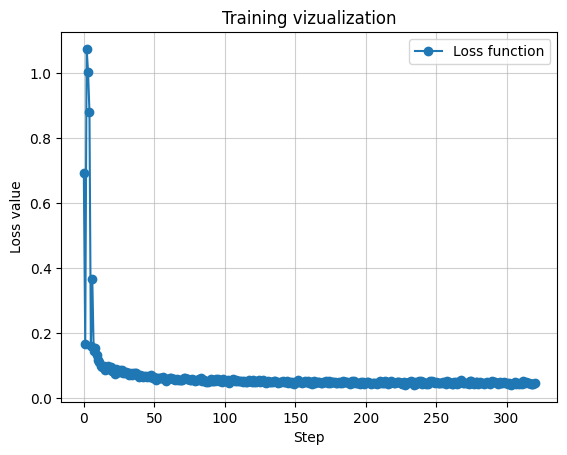

In [25]:
import matplotlib.pyplot as plt

plt.plot(losses_mb, label="Loss function", marker='o')
plt.grid(True, alpha=0.6)
plt.xlabel("Step")
plt.ylabel("Loss value")
plt.title("Training vizualization")
plt.legend()
plt.savefig("training_viz_mb")